In [1]:
from selenium import webdriver

## Render page and retrieve window size
Insantiate a Chrome webdriver and load the page. Adjust the window size of the webdriver to be the size of the rendered page to avoid clipping content from view.

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
driver = webdriver.Chrome(
    executable_path="../bin/chromedriver",
    options=chrome_options)
url = 'http://localhost:3000/margins.html'
driver.get(url)  # must be running a localserver in the viz/ dir
rendered_width = driver.execute_script("return document.documentElement.scrollWidth")
rendered_height = driver.execute_script("return document.documentElement.scrollHeight")
driver.set_window_size(rendered_width,rendered_height)
print(f"window dims H:{rendered_height} X W:{rendered_width}")   

window dims H:600 X W:810


## Plot size and margins
The plot margins are stored in an object. Next, the width and height are declared in a way that we can conceptually think of them as the entire drawing area of the plot _minus_ the margins. 

This is known as the ['margin convention'](https://observablehq.com/@d3/margin-convention).
```
// .js code
var margin = { top: 20, right: 20, bottom: 100, left: 80 },
width = 800 - margin.left - margin.right,
height = 400 - margin.top - margin.bottom;
```

## `svg` element
The entire plot will be drawn within an `svg` elmement. This element is scaled to the `width=800` and `height=400`.  Notice again that we use the relationship of the width and height to the margins by adding them when we set the respective attributes.  

This practice enables us to set the height & width margins according to our original size and margin specification in one location and then allows us to refer to it throughout the visualization without explicitly setting the values `800` and `400` _i.e.,_ avoid using "magic numbers".
```
// .js code
var svg = d3.select("body")
    .append("svg")
    .attr("id", "container")
    .attr("width", width + margin.left + margin.right)
    .attr("height", height + margin.bottom + margin.top);
```
(The retrieved dimensions of the `svg` account for a 1 px border)

In [3]:
svg = driver.find_element_by_id("container")
svg_src = svg.get_attribute("outerHTML")
svg_transform = svg.value_of_css_property("transform")
print(f"svg dims H:{svg.size['height']} X W:{svg.size['width']}")
print(f"svg transform: {svg_transform}")

svg dims H:402 X W:802
svg transform: none


## `g` element layout and sizing
A grouping `g` element is used to hold the plot elements.  Since the origin is oriented at the top-left, this element is translated using the top and left margin values.
```
// .js code
var plot = svg.append("g")
    .attr("id","plot")
    .attr("transform", "translate("+margin.left+","+margin.top+")");
```
The translation of the `g` element can be retrieved using a CSS `transform` lookup.  The last two values in the matrix represent the `xy` transform.

In [4]:
g = driver.find_element_by_id("plot")
g_transform = g.value_of_css_property("transform")
print(f"group transform: {g_transform}")

group transform: matrix(1, 0, 0, 1, 80, 20)


To demonstrate the plot area within the `g` nested in the `svg`, we insert a `rect` element.
```
//.js code
var plot_area = plot.append("rect")
    .attr("id", "plot_area")
    .attr("width", width)
    .attr("height", height);
```
We use the webdriver to capture a screenshot of our viz area so far:

In [5]:
driver.set_window_size(svg.size['width']+10,svg.size['height']+20)
svg_coords = svg.location_once_scrolled_into_view 
driver.execute_script('window.scrollTo({}, {});'.format(svg_coords['x'], svg_coords['y']))
driver.save_screenshot("img/svg.png")
driver.set_window_size(rendered_width, rendered_height)

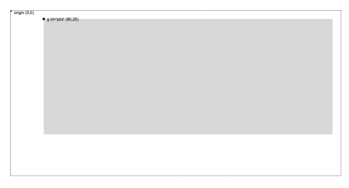

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    
img = mpimg.imread('img/svg.png')
fig, ax = plt.subplots()
ax.set_axis_off()
imgplot = plt.imshow(img)